In [1]:
# Ensure that local modules are reloaded when edited
%load_ext autoreload
%autoreload 2

# Ensure that plots are displayed
%matplotlib inline

In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../..')))

https://machinelearningmastery.com/training-the-transformer-model/

In [3]:
from time import time

In [4]:
from utils.dataset import Dataset
from utils.enums import EncodingCategorical, EncodingNumerical

dataset_name='medium_debug_v2-0.15-4_1.json.gz'
prefix=True
pretrain_percentage=0.0
w2v_vector_size=20
w2v_window_size=4
categorical_encoding=EncodingCategorical.WORD_2_VEC
numerical_encoding=EncodingNumerical.MIN_MAX_SCALING
fs_save=None

dataset = Dataset(dataset_name, 
                      beta=0.005, 
                      prefix=prefix,
                      pretrain_percentage=pretrain_percentage,
                      w2v_vector_size=w2v_vector_size,
                      w2v_window_size=w2v_window_size, 
                      categorical_encoding=categorical_encoding,
                      numerical_encoding=numerical_encoding,
                      fs_save=fs_save)

c:\Users\ronal\miniconda3\envs\rcvdb-thesis-bpad\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


EncodingNumerical.MIN_MAX_SCALING EncodingNumerical.MIN_MAX_SCALING
0.0 81.0
0.0 1.0
EncodingNumerical.MIN_MAX_SCALING EncodingNumerical.MIN_MAX_SCALING
0.0 159.0
0.0 1.0
EncodingNumerical.MIN_MAX_SCALING EncodingNumerical.MIN_MAX_SCALING
0.0 27.0
0.0 1.0
EncodingNumerical.MIN_MAX_SCALING EncodingNumerical.MIN_MAX_SCALING
0.0 54.0
0.0 1.0
EncodingNumerical.MIN_MAX_SCALING EncodingNumerical.MIN_MAX_SCALING
0.0 12.0
0.0 1.0
Feature Columns: dict_keys(['name', 'arrival_time', 'company', 'country', 'department', 'global_workload_D', 'global_workload_h', 'local_workload_D', 'local_workload_h', 'user'])
Feature Shape: (35483, 13)
Case Length: [ 2  2  3 ...  8 10 10]
Attribute Types: [<AttributeType.CATEGORICAL: 0>, <AttributeType.NUMERICAL: 1>, <AttributeType.CATEGORICAL: 0>, <AttributeType.CATEGORICAL: 0>, <AttributeType.CATEGORICAL: 0>, <AttributeType.NUMERICAL: 1>, <AttributeType.NUMERICAL: 1>, <AttributeType.NUMERICAL: 1>, <AttributeType.NUMERICAL: 1>, <AttributeType.CATEGORICAL: 0>]
Enc

# W2V Encoding

In [5]:
from utils.embedding.w2v import ProcessWord2Vec
import numpy as np

In [6]:
dataset.case_lens[0:20]

array([2, 2, 3, 3, 2, 2, 2, 2, 2, 3, 2, 4, 5, 5, 5, 5, 3, 2, 3, 3])

In [7]:
np.mean(dataset.case_lens)

5.491164783135586

In [8]:
dataset.features[0].shape

(35483, 13)

In [9]:
np.set_printoptions(linewidth=200)
dataset.features[2][0:20]

array([[ 1., 82.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1., 82.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1., 82., 83.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1., 82., 83.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1., 84.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1., 82.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1., 84.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1., 84.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1., 82.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1., 84., 85.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1., 84.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1., 84., 85., 85.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1., 82., 83., 86.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1., 82., 83., 86.,  2.,  0., 

In [10]:
np.set_printoptions(linewidth=300)
dataset.features[5][0:20]

array([[0.        , 0.01886792, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.01886792, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.01886792, 0.01886792, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.01886792, 0.22012579, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.22012579, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.22012579, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.

In [11]:
w2v_encoder = ProcessWord2Vec(
            encoders=dataset.encoders,
            pretrain_percentage=dataset.pretrain_percentage,
            attribute_types=dataset.attribute_types,
            event_attribute_keys=dataset.event_log.event_attribute_keys,
            features=dataset._features,
            event_log=dataset.event_log,
            vector_size=dataset.w2v_vector_size,
            window=dataset.w2v_window_size,
            fs_save=dataset.fs_save) 

In [12]:
w2v_features, numeric_features, numeric_feature_names, w2v_feature_names = w2v_encoder.encode_features(average=False, match_numerical=True)

In [13]:
# (num_attribute, num_cases, num_events, vector_size) 
print(w2v_features.shape)
transposed_w2v_features = np.transpose(w2v_features, (1, 2, 0, 3))
print(transposed_w2v_features.shape)

(5, 35483, 13, 20)
(35483, 13, 5, 20)


In [14]:
print(numeric_features.shape)
transposed_numeric_features = np.transpose(numeric_features, (1, 2, 0, 3))
print(transposed_numeric_features.shape)

(5, 35483, 13, 20)
(35483, 13, 5, 20)


In [15]:
dataset.case_lens[13]

5

In [16]:
transposed_numeric_features[12,:,0]

array([[0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.07749242, 0.1545188 , 0.23061587, 0.30532598, 0.37819985, 0.4487992 , 0.5166994 , 0.58149207, 0.64278764, 0.70021737, 0.99699295, 0.98798984, 0.9730449 , 0.95224786, 0.92572397, 0.89363265, 0.8561669 , 0.8135521 , 0.76604444, 0.7139297 ],
       [0.11609291, 0.23061587, 0.34202015, 0.4487992 , 0.549509  , 0.64278764, 0.72737366, 0.8021232 , 0.8660254 , 0.9182161 , 0.99323833, 0.9730449 , 0.9396926 , 0.89363265, 0.8354878 , 0.76604444, 0.6862416 , 0.5971586 , 0.5       , 0.39607978],
    

In [17]:
transposed_w2v_features[12,:,0]

array([[-0.01569275,  0.03015446, -0.03076373, -0.0099005 , -0.02991541, -0.0049784 , -0.01010493,  0.04242973,  0.00039001, -0.04287663, -0.02714549, -0.03437993,  0.01346191,  0.04728324, -0.02907998,  0.04132513,  0.04266026, -0.0353132 , -0.04441606,  0.04734592],
       [ 0.02424864, -0.03082013,  0.01259593,  0.0036972 , -0.01696077, -0.00489612,  0.04989563,  0.04572944, -0.02230915,  0.04541513, -0.02820882,  0.02965461, -0.01548609,  0.01715876,  0.01508613,  0.03450231, -0.01186942,  0.04387518,  0.03794714, -0.04773823],
       [-0.04004105, -0.03818948,  0.01461629, -0.01397361, -0.0346476 , -0.04064132,  0.0415459 ,  0.00995244, -0.04664009, -0.02396358,  0.01568369, -0.02356603,  0.02640421, -0.02116721,  0.01320898, -0.04022844,  0.03104943,  0.02409444,  0.00393596,  0.01506724],
       [ 0.04776092, -0.03678212, -0.03635194, -0.01132694, -0.0038928 , -0.01608052, -0.00296293,  0.03744411, -0.00348759, -0.0081247 ,  0.013722  , -0.0417955 ,  0.03927902,  0.04268052, -0.

In [18]:
# Shapes of the input data
num_traces, num_events, num_numeric_features, vector_size = transposed_numeric_features.shape
_, _, num_w2v_features, _ = transposed_w2v_features.shape

# Initialize the merged array
merged_features = np.zeros((num_traces, num_events, num_numeric_features + num_w2v_features, vector_size))

# Keep track of the current indices for numeric and w2v features
numeric_index, w2v_index = 0, 0

# Iterate over dataset.attribute_keys to place each feature in the correct order
for i, key in enumerate(dataset.attribute_keys):
    # print(key)
    if key in numeric_feature_names:
        # print("Numeric feature shape:", transposed_numeric_features[:, :, numeric_index, :].shape)
        # print("Target shape:", merged_features[:, :, i, :].shape)
        # print(numeric_index)
        # Place numeric feature in the merged array
        merged_features[:, :, i, :] = transposed_numeric_features[:, :, numeric_index, :]
        numeric_index += 1
    elif key in w2v_feature_names:
        # print("W2V feature shape:", transposed_w2v_features[:, :, w2v_index, :].shape)
        # print("Target shape:", merged_features[:, :, i, :].shape)
        # print(w2v_index)
        # Place w2v feature in the merged array
        merged_features[:, :, i, :] = transposed_w2v_features[:, :, w2v_index, :]
        w2v_index += 1
    else:
        raise ValueError(f"Unexpected attribute key '{key}' not found in either feature list.")

# The merged array now has features interlaced according to dataset.attribute_keys order
print("Merged features shape:", merged_features.shape)

Merged features shape: (35483, 13, 10, 20)


In [19]:
dataset.case_lens[10:20]

array([2, 4, 5, 5, 5, 5, 3, 2, 3, 3])

In [20]:
merged_features[12][4]

array([[ 0.00890996, -0.0341445 , -0.04862406,  0.04520292,  0.03099027, -0.03456464,  0.01701741,  0.00103032,  0.02376873, -0.03559972,  0.02013477,  0.02173717,  0.04978685, -0.0223687 , -0.00694632, -0.03658661, -0.04848915, -0.04540129, -0.00511377, -0.03251645],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.03949034, -0.03494752, -0.04577933, -0.00177876, -0.0154992 ,  0.03947159,  0.02969287, -0.00772831,  0.00755482,  0.0089502 ,  0.03908785, -0.04755094, -0.00102766,  0.01734598, -0.00469486,  0.04190886,  0.04505392,  0.03268253, -0.00355811,  0.03855202],
       [-0.04801775,  0.02503647, -0.04379793, -0.02195913, -0.0001755 , -0.00148091, -0.0383062 ,  0.04807372,  0.02491029,  0.04616572, -0.04078959,  0.02247899, -0.02068538,  0.00412268,  0.

In [21]:
zero_event = np.zeros((num_numeric_features + num_w2v_features, vector_size))

trainX = []
trainY = []
for case, length in zip(merged_features, dataset.case_lens):
    last_event_index = length - 1
    trainY.append(case[length - 1].copy())

    # Remove the target event from the training data
    case[length - 1] = zero_event
    trainX.append(case)

trainX = np.array(trainX)
trainY = np.array(trainY)

In [22]:
trainX.shape

(35483, 13, 10, 20)

In [23]:
trainY.shape

(35483, 10, 20)

In [24]:
trainY[4]

array([[ 2.42486410e-02, -3.08201313e-02,  1.25959273e-02,  3.69720464e-03, -1.69607699e-02, -4.89611644e-03,  4.98956256e-02,  4.57294360e-02, -2.23091487e-02,  4.54151332e-02, -2.82088164e-02,  2.96546109e-02, -1.54860914e-02,  1.71587579e-02,  1.50861321e-02,  3.45023051e-02, -1.18694184e-02,
         4.38751802e-02,  3.79471406e-02, -4.77382317e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-4.28278465e-03,  1.41328154e-02,  2.70071439e-02,  3.52632813e-02, -2.85156071e-02,  9.29409824e-03,  3.04443184e-02, -2.39902548e-02, -1.55363027e-02,  3.39881480e-02,  8.15737806e-03,  9.49585461e-04,  1.73681863e-02,  1.08888745e-03,  4.80941311e-02,  2.53030173e-02, -4.458

In [25]:
trainX[4,0]

array([[-0.01569275,  0.03015446, -0.03076373, -0.0099005 , -0.02991541, -0.0049784 , -0.01010493,  0.04242973,  0.00039001, -0.04287663, -0.02714549, -0.03437993,  0.01346191,  0.04728324, -0.02907998,  0.04132513,  0.04266026, -0.0353132 , -0.04441606,  0.04734592],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-0.04267167,  0.01603553, -0.02318999, -0.02544478,  0.01794809,  0.0268517 ,  0.03884757, -0.02883253,  0.0371668 ,  0.03312748, -0.018549  , -0.04372821,  0.02718734,  0.03254878, -0.00393775, -0.03354928, -0.03542963, -0.0124853 ,  0.02571627, -0.01832619],
       [ 0.00386665, -0.04247889,  0.03904903,  0.04628646, -0.01371164,  0.00400112,  0.00373326,  0.02738943, -0.04303039,  0.00292228,  0.03434711,  0.01115797,  0.00562338, -0.04661078,  0.

In [26]:
dim0, dim1, dim2, dim3 = trainX.shape
trainX = np.reshape(trainX, (dim0, dim1, dim2 * dim3))#, order='C')
trainX = np.reshape(trainX, (dim0, dim1 * dim2 * dim3))#, order='C')
trainX.shape

(35483, 2600)

In [27]:
dim0, dim1, dim2 = trainY.shape
trainY = np.reshape(trainY, (dim0, dim1 * dim2))#, order='C')
trainY.shape

(35483, 200)

# Token Encoding

In [28]:
features = np.array(dataset.features)
cases = np.transpose(features, (1, 2, 0))

In [29]:
# Debug Prints
print(features.shape)
print(cases.shape)
print(len(dataset.case_lens))
print(dataset.attribute_types)
print(dataset.event_log.event_attribute_keys)

(10, 35483, 13)
(35483, 13, 10)
35483
[<AttributeType.CATEGORICAL: 0>, <AttributeType.NUMERICAL: 1>, <AttributeType.CATEGORICAL: 0>, <AttributeType.CATEGORICAL: 0>, <AttributeType.CATEGORICAL: 0>, <AttributeType.NUMERICAL: 1>, <AttributeType.NUMERICAL: 1>, <AttributeType.NUMERICAL: 1>, <AttributeType.NUMERICAL: 1>, <AttributeType.CATEGORICAL: 0>]
['name', 'arrival_time', 'company', 'country', 'department', 'global_workload_D', 'global_workload_h', 'local_workload_D', 'local_workload_h', 'user']


In [30]:
# Categorical filter TODO make sure the transformer model can also handle numerical values via multitask learning
from utils.enums import AttributeType

# Create a boolean mask for categorical attributes
categorical_mask = np.array(dataset.attribute_types) == AttributeType.CATEGORICAL
print(categorical_mask)
num_categorical_features = np.sum(categorical_mask)

# Use this mask to filter out only the categorical attributes in the last axis
categorical_cases = cases[..., categorical_mask]
print(categorical_cases.shape)

[ True False  True  True  True False False False False  True]
(35483, 13, 5)


In [31]:
categorical_keys = []
for type, key in zip(dataset.attribute_types, dataset.event_log.event_attribute_keys):
    if type == AttributeType.CATEGORICAL:
        categorical_keys.append(key)
print(categorical_keys)

['name', 'company', 'country', 'department', 'user']


In [32]:
print(dataset.case_lens)

[ 2  2  3 ...  8 10 10]


In [33]:
zero_event = np.zeros((num_categorical_features))
print(zero_event.shape)

trainX_categorical = []
trainY_categorical = []
for index, (case, case_length) in enumerate(zip(categorical_cases, dataset.case_lens)):
    last_event_index = case_length - 1
    trainY_categorical.append(case[last_event_index].copy())

    # Remove the target event from the training data
    case[last_event_index] = zero_event
    trainX_categorical.append(case)

trainX_categorical = np.array(trainX_categorical, dtype=np.int64)
trainY_categorical = np.array(trainY_categorical, dtype=np.int64)

print(trainX_categorical.shape)
print(trainY_categorical.shape)

(5,)
(35483, 13, 5)
(35483, 5)


In [34]:
dim0, dim1, dim2 = trainX_categorical.shape
trainX_categorical = np.reshape(trainX_categorical, (dim0, dim1 * dim2))#, order='C')
trainX_categorical.shape

(35483, 65)

In [35]:
print(trainX_categorical[12])

[  1   1   1   1   1   5  82  91 113 135   6  83  92 115 137   9  86  98 120 144   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [36]:
trainX_categorical[12,0:5]

array([1, 1, 1, 1, 1], dtype=int64)

In [37]:
trainX_categorical[12,5:]

array([  5,  82,  91, 113, 135,   6,  83,  92, 115, 137,   9,  86,  98, 120, 144,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0], dtype=int64)

In [38]:
trainY_categorical[0:20]

array([[  5,  82,  91, 113, 135],
       [  5,  82,  91, 114, 136],
       [  6,  83,  92, 115, 137],
       [  6,  83,  92, 116, 138],
       [  5,  84,  93, 117, 139],
       [  5,  82,  94, 118, 140],
       [  5,  84,  93, 117, 139],
       [  5,  84,  93, 117, 139],
       [  5,  82,  95, 114, 141],
       [  7,  85,  96, 119, 142],
       [  5,  84,  93, 117, 139],
       [  8,  85,  97, 119, 143],
       [  2,   2,   2,   2,   2],
       [  2,   2,   2,   2,   2],
       [  2,   2,   2,   2,   2],
       [  2,   2,   2,   2,   2],
       [  7,  82,  91, 118, 145],
       [  5,  84,  93, 117, 139],
       [  6,  83,  95, 115, 146],
       [  7,  85,  96, 119, 142]], dtype=int64)

In [39]:
print(trainY_categorical[12])

[2 2 2 2 2]


In [40]:
vocab_size = 0
for encoder in dataset.encoders.values():
    largest_index = encoder.largest_attribute()
    if largest_index > vocab_size:
        vocab_size = largest_index + 1

In [41]:
vocab_size

235

# Online Process Transformer Implementation

In [42]:
from keras.optimizers import Adam # type: ignore
from keras.metrics import Mean # type: ignore
from tensorflow import data, train, GradientTape, function # type: ignore

from novel.transformer.components.transformer import TransformerModel
from novel.transformer.components.utils import LRScheduler, loss_fcn, accuracy_fcn, likelihood_fcn

In [43]:
# Define the model parameters

h = 8  # Number of self-attention heads
d_k = 64  # Dimensionality of the linearly projected queries and keys
d_v = 64  # Dimensionality of the linearly projected values
d_model = 512  # Dimensionality of model layers' outputs
d_ff = 2048  # Dimensionality of the inner fully connected layer
n = 6  # Number of layers in the encoder stack

# Define the training parameters
batch_size = 32
beta_1 = 0.9
beta_2 = 0.98
epsilon = 1e-9
dropout_rate = 0.1

# Instantiate an Adam optimizer
optimizer = Adam(LRScheduler(d_model), beta_1, beta_2, epsilon)

# Prepare the training and test splits of the dataset
# dataset = PrepareDataset()
# trainX, trainY, train_orig, enc_seq_length, dec_seq_length, enc_vocab_size, dec_vocab_size = dataset('english-german-both.pkl')
# print(f'X Length: {trainX.shape}')
enc_seq_length = trainX_categorical.shape[1]
dec_seq_length = trainY_categorical.shape[1]
# h = 10

print(enc_seq_length, "Encoding Sequence Length")
print(dec_seq_length, "Decoding Sequence Length")


# d_model = enc_seq_length
# d_ff = enc_seq_length

# Prepare the dataset batches
train_dataset = data.Dataset.from_tensor_slices((trainX_categorical, trainY_categorical))
train_dataset = train_dataset.batch(batch_size)

# Create model
training_model = TransformerModel(
    enc_seq_length, 
    dec_seq_length, 
    h, d_k, 
    d_v, 
    d_model, 
    d_ff, 
    n, 
    dropout_rate,
    enc_vocab_size=vocab_size,
    dec_vocab_size=vocab_size)

# Include metrics monitoring
train_loss = Mean(name='train_loss')
train_accuracy = Mean(name='train_accuracy')
train_likelihood = Mean(name='train_likelihood')

# Create a checkpoint object and manager to manage multiple checkpoints
ckpt = train.Checkpoint(model=training_model, optimizer=optimizer)
ckpt_manager = train.CheckpointManager(ckpt, "./checkpoints", max_to_keep=3)

65 Encoding Sequence Length
5 Decoding Sequence Length


In [44]:
predictions = []
targets = []
losses = []

# Speeding up the training process
@function
def train_step(encoder_input, decoder_input, decoder_output):
    with GradientTape() as tape:
        prediction = training_model(encoder_input, decoder_input, training=True)

        loss = loss_fcn(decoder_output, prediction)
        accuracy = accuracy_fcn(decoder_output, prediction)
        likelihood = likelihood_fcn(decoder_output, prediction)

    gradients = tape.gradient(loss, training_model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, training_model.trainable_weights))

    train_loss(loss)
    train_accuracy(accuracy)
    train_likelihood(likelihood)

    return loss, prediction, decoder_output

train_loss.reset_states()
train_accuracy.reset_states()
train_likelihood.reset_states()

print(f"\nStart of training in {len(train_dataset)} batches")

start_time = time()

for step, (train_batchX, train_batchY) in enumerate(train_dataset):
    encoder_input = train_batchX[:, num_categorical_features:] #1:] #Skip the start symbol
    decoder_input =  train_batchY[:, 0:num_categorical_features]    #train_batchY[:, :-1] 
    decoder_output = train_batchY[:, :]

    # print(encoder_input.shape, "Encoder Input")
    # print(decoder_input.shape, "Decoder Input")
    # print(decoder_output.shape, "Decoder Output")

    loss, prediction, target = train_step(encoder_input, decoder_input, decoder_output)

    losses.append(loss.numpy())
    predictions.append(prediction.numpy())
    targets.append(decoder_output.numpy())

    if step % 25 == 0:
        print(f'Step {step} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f} Likelihood {train_likelihood.result():.4f}')

# Print epoch number and loss value at the end of every epoch
print("Training Loss %.4f, Training Accuracy %.4f, Training Likelihood %.4f" % (train_loss.result(), train_accuracy.result(), train_likelihood.result()))

print("Total time taken: %.2fs" % (time() - start_time))


Start of training in 1109 batches
(32, 1, 1, 60) Mask
(32, 1, 1, 5) Mask
(32, 1, 1, 60) Mask
(32, 1, 1, 5) Mask
Step 0 Loss 6.3957 Accuracy 0.0000 Likelihood 0.0043
Step 25 Loss 5.8037 Accuracy 0.0764 Likelihood 0.0043
Step 50 Loss 5.1717 Accuracy 0.1665 Likelihood 0.0045
Step 75 Loss 4.6275 Accuracy 0.2232 Likelihood 0.0049
Step 100 Loss 4.2463 Accuracy 0.2607 Likelihood 0.0052
Step 125 Loss 3.9372 Accuracy 0.2965 Likelihood 0.0054
Step 150 Loss 3.6695 Accuracy 0.3309 Likelihood 0.0056
Step 175 Loss 3.3780 Accuracy 0.3752 Likelihood 0.0059
Step 200 Loss 3.1172 Accuracy 0.4158 Likelihood 0.0061
Step 225 Loss 2.8856 Accuracy 0.4531 Likelihood 0.0063
Step 250 Loss 2.6751 Accuracy 0.4899 Likelihood 0.0066
Step 275 Loss 2.4878 Accuracy 0.5236 Likelihood 0.0068
Step 300 Loss 2.3195 Accuracy 0.5545 Likelihood 0.0070
Step 325 Loss 2.1690 Accuracy 0.5826 Likelihood 0.0072
Step 350 Loss 2.0364 Accuracy 0.6073 Likelihood 0.0074
Step 375 Loss 1.9186 Accuracy 0.6295 Likelihood 0.0076
Step 400 Los

# Output analysis

In [45]:
len(predictions)

1109

In [46]:
predictions[0].shape

(32, 5, 235)

In [47]:
targets[0].shape

(32, 5)

In [48]:
print(losses)

[6.395739, 6.3081207, 6.61512, 6.506172, 6.664038, 6.4746184, 6.4007187, 6.354959, 6.5952086, 6.376531, 6.2597146, 6.2344155, 5.980102, 6.0094814, 5.9207115, 5.84421, 5.2767878, 5.5168676, 5.043846, 5.4472184, 5.2667947, 4.306321, 4.749831, 4.4116125, 4.892785, 5.043809, 4.259444, 3.733687, 5.8095994, 5.280116, 4.9849386, 5.0750895, 4.333449, 4.39882, 5.8250785, 3.1376271, 4.9810658, 4.777396, 4.8909354, 3.988797, 4.183619, 3.572824, 4.4074, 4.380287, 4.5010204, 4.222226, 4.1601934, 4.62439, 4.3405085, 4.664657, 4.32817, 3.4794583, 3.9750698, 4.0948563, 3.9958272, 2.684262, 3.346814, 3.8008587, 3.6720474, 3.0221276, 3.459375, 3.4001708, 4.24083, 3.505095, 3.8437133, 3.7755265, 3.6297257, 3.9566593, 3.4384685, 3.2433445, 4.0225163, 3.3834503, 3.274086, 2.688027, 2.850409, 3.1531336, 3.1559205, 3.056403, 3.4321327, 2.955316, 3.6422725, 3.075932, 3.5674443, 2.6181564, 3.2835567, 3.8487847, 3.8991191, 2.651678, 3.6990063, 2.3417392, 2.6533897, 2.729802, 2.0459695, 2.545595, 3.1544042, 3.58

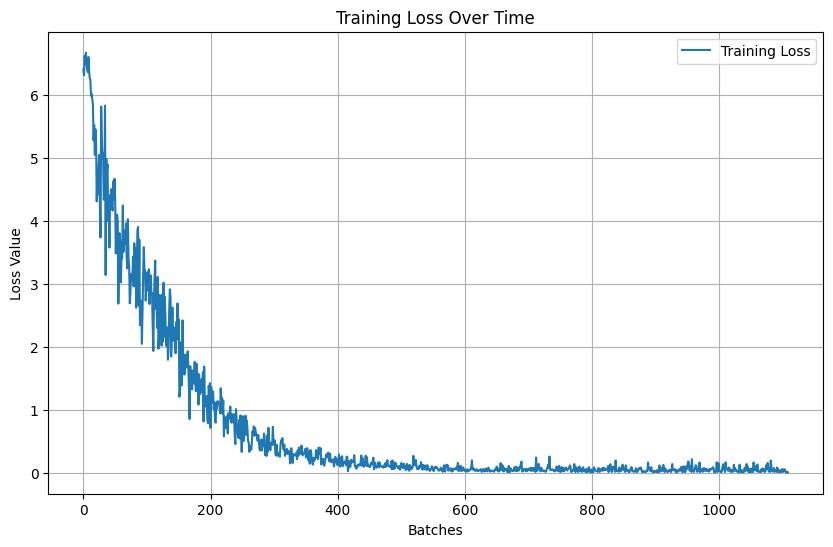

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(losses, label='Training Loss')
plt.xlabel('Batches')
plt.ylabel('Loss Value')
plt.title('Training Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [50]:
predictions = np.vstack(predictions)

In [51]:
predictions[0,0]

array([8.24549235e-04, 5.41221816e-05, 4.22996149e-04, 1.71415636e-03, 3.14074894e-03, 1.61093788e-03, 2.37414706e-03, 7.00770924e-03, 8.69964529e-03, 5.26914198e-04, 1.11866160e-03, 1.30157929e-03, 8.78538750e-03, 2.66162232e-02, 4.87791980e-03, 5.04261395e-03, 3.22988228e-04, 3.37451842e-04,
       2.18979339e-03, 2.66546127e-03, 2.98353116e-04, 2.41472339e-03, 2.97255162e-03, 3.52925825e-04, 6.19726197e-04, 7.72639120e-04, 1.76194012e-02, 8.93235789e-04, 5.80048829e-04, 2.44173571e-03, 5.50529745e-04, 3.43179563e-03, 2.13018642e-03, 1.21244602e-02, 1.07043394e-04, 1.97701761e-03,
       4.04800335e-03, 4.38730960e-04, 9.06599045e-04, 7.74868531e-03, 2.04822654e-03, 5.61876455e-03, 1.47148045e-02, 9.19736282e-04, 3.38263664e-04, 2.47734599e-03, 3.13963246e-04, 9.45878681e-03, 1.04699202e-03, 1.05433799e-02, 9.28443682e-04, 3.87373031e-03, 1.04287930e-03, 1.98294548e-03,
       3.57458775e-04, 1.10722473e-03, 5.77769009e-03, 6.34033652e-03, 3.29525187e-03, 2.02145404e-03, 6.32624549e-

In [123]:
import numpy as np
import matplotlib.pyplot as plt

def plot_prediction_bar_chart(predictions, word_labels=None):
    """
    Plots a bar chart of predicted word likelihoods.

    Parameters:
        predictions (np.ndarray): Array of probabilities (likelihoods) between 0 and 1.
        word_labels (list, optional): List of labels corresponding to the predictions. 
                                       If None, default labels will be used.
    """
    # Validate the input
    if not isinstance(predictions, np.ndarray):
        raise ValueError("Predictions should be a numpy array.")
    
    predictions = np.maximum(predictions, 0)
    num_predictions = len(predictions)
    
    # Create default word labels if none are provided
    if word_labels is None:
        word_labels = [f'Word {i}' for i in range(num_predictions)]

    # Create a bar chart
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.bar(word_labels, predictions, color='skyblue')  # Create bar chart

    # Add titles and labels
    plt.title('Predicted Word Likelihoods')
    plt.xlabel('Words')
    plt.ylabel('Likelihood (Probability)')
    # plt.ylim(0, 1)  # Set the y-axis limit to 0 and 1

    plt.xticks([])

    # Show the probability values on top of the bars
    # for i, v in enumerate(predictions):
    #     plt.text(i, v + 0.02, f"{v:.2f}", ha='center', va='bottom')

    # Display the bar chart
    plt.show()

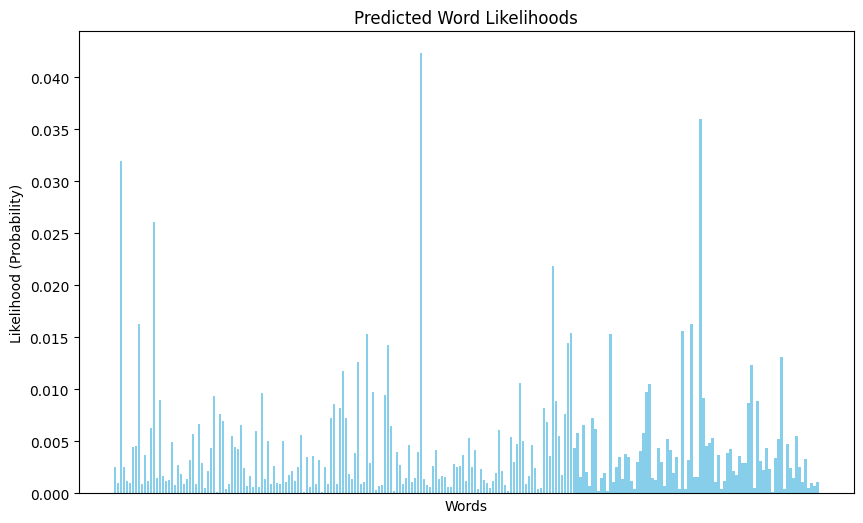

In [142]:
plot_prediction_bar_chart(predictions[600,3])

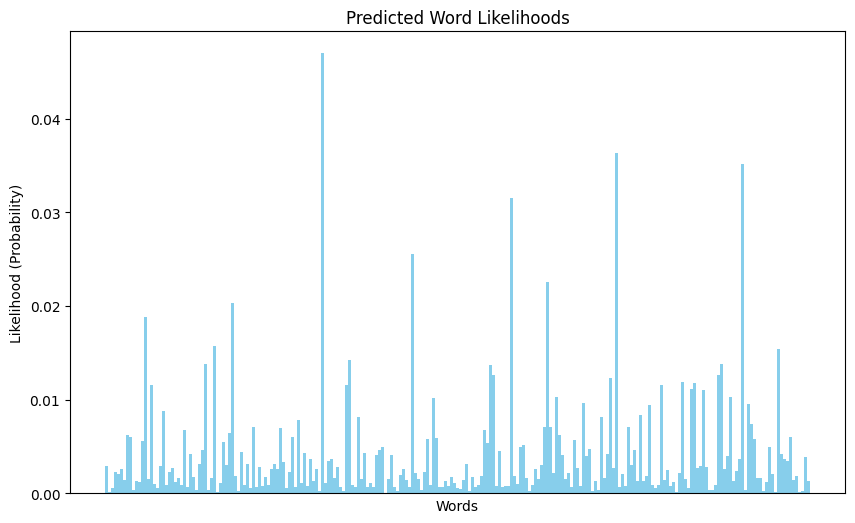

In [145]:
plot_prediction_bar_chart(predictions[1,3])

In [54]:
trainY_categorical.shape

(35483, 5)

In [55]:
predictions.shape

(35483, 5, 235)

In [56]:
trainY_categorical[20000,0]

2

In [57]:
predictions[20000,0]

array([3.4352759e-06, 2.1731344e-06, 9.9941742e-01, 1.9545715e-07, 7.5309214e-07, 1.6777778e-04, 4.7986873e-07, 1.0985866e-06, 2.8776508e-06, 1.9381916e-06, 6.4217670e-06, 1.2186842e-06, 6.6246082e-07, 4.0471551e-07, 1.0139493e-06, 1.6560849e-06, 3.3698404e-06, 3.3242404e-08, 4.3800767e-07,
       1.0315119e-06, 7.3395483e-08, 2.1325445e-07, 4.7756981e-08, 1.8861812e-05, 2.1686149e-06, 2.9224668e-05, 2.5700263e-06, 4.6956777e-07, 4.9335137e-07, 2.6451684e-07, 1.3063756e-06, 1.0182868e-06, 1.6892540e-06, 1.0142259e-06, 1.4338461e-05, 4.1960989e-06, 5.9342068e-07, 2.4080821e-06,
       1.0853146e-06, 8.2595670e-07, 3.7965231e-07, 8.8893648e-07, 4.2921235e-07, 5.7055155e-07, 4.2635643e-06, 1.7083776e-06, 4.3216037e-06, 2.2524728e-06, 1.4678011e-07, 4.6994546e-07, 6.6003605e-07, 2.2790025e-06, 1.8446651e-06, 5.4678562e-06, 1.1422687e-06, 1.1695844e-06, 5.4922339e-07,
       6.9652498e-07, 1.4115942e-06, 1.7805353e-07, 3.4555458e-06, 2.6508642e-06, 5.0145422e-07, 8.0989940e-07, 1.4530955e-0

In [58]:
max(predictions[20000,0])

0.9994174

In [59]:
likelihood_errors = np.zeros(trainY_categorical.shape)
for i, (event_pred, event_true) in enumerate(zip(predictions, trainY_categorical)):
    for j, (attribute_pred, attribute_true) in enumerate(zip(event_pred, event_true)):
        likelihood_true = attribute_pred[attribute_true]
        likelihood_pred = 0
        for pred in attribute_pred:
            if pred > likelihood_true:
                likelihood_pred += pred
        likelihood_errors[i,j] = likelihood_pred
        
likelihood_errors = np.transpose(likelihood_errors, (1, 0))

In [60]:
likelihood_errors.shape

(5, 35483)

In [61]:
import matplotlib.pyplot as plt
import numpy as np

def plot_lines(errors, keys, title='Likelihood Errors per attribute over time', xlabel='Case Index', ylabel='Likelihood Error'):
    plt.figure(figsize=(12, 6))

    for i in range(errors.shape[0]):
        plt.plot(errors[i], label=keys[i])

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

In [62]:
def rolling_average_np(errors, window_size=10):
    kernel = np.ones(window_size) / window_size
    rolling_avg = np.array([np.convolve(attribute, kernel, mode='valid') for attribute in errors])
    return rolling_avg

smoothed_likelihood_errors = rolling_average_np(likelihood_errors, window_size=100)
print(smoothed_likelihood_errors.shape)

(5, 35384)


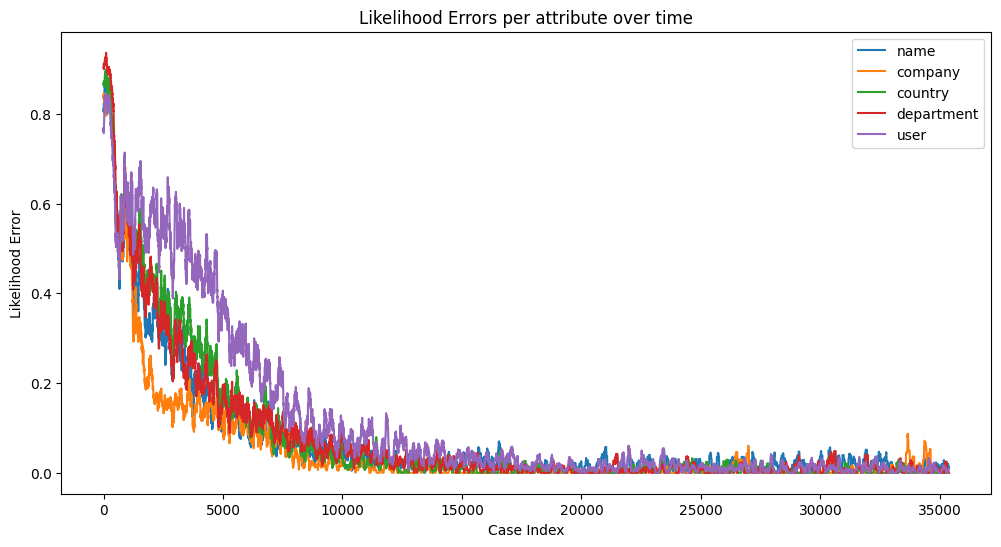

In [63]:
plot_lines(smoothed_likelihood_errors, categorical_keys)

In [64]:
from utils.enums import Perspective
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def plot_losses(results, labels, perspective, level, bucket=None, zoom=[[11000,13000],[-0.05, 0.2]]):
    def scatter_plot(ax, results, labels):
        y_values = results
        x_values = np.arange(len(results))
        ax.scatter(x_values[labels == 0], y_values[labels == 0], c='grey', s=3, label='Normal Prefixes', zorder=1)
        ax.scatter(x_values[labels == 1], y_values[labels == 1], c='red', s=3, label='Anomalous Prefixes', zorder=2)
        ax.grid(True)

    fig, ax = plt.subplots(figsize=(15, 6))

    labels = labels[:, perspective]
    scatter_plot(ax, results, labels)
    
    perspective_name = Perspective.values()[perspective]

    bucket_string = ''
    if bucket is not None:
        bucket_string = f'with bucket size {str(bucket)}'
    plt.title(f'Error per Prefix on the {perspective_name} perspective at {level} level {bucket_string}')
    plt.xlabel('Prefix Index')
    plt.ylabel('Loss')
    
    if zoom:
        axins = inset_axes(ax, width="60%", height="60%", loc='upper right')

        scatter_plot(axins, results, labels)
        axins.set_xlim(zoom[0])
        axins.set_ylim(zoom[1])
        _,_ = ax.indicate_inset_zoom(axins, edgecolor="black", linewidth=3)

    plt.xlabel('Batch Index')
    plt.ylabel('Error')
    plt.legend(loc='upper right')
    plt.show()

In [65]:
dataset.case_labels.shape

(35483, 4)

In [66]:
dataset.event_labels.shape

(35483, 13, 4)

In [67]:
dataset.attr_labels.shape

(35483, 13, 10, 4)

In [68]:
likelihood_errors.shape

(5, 35483)

In [69]:
perspective_likelihood_errors = likelihood_errors.copy()

In [70]:
perspective_likelihood_errors = np.transpose(perspective_likelihood_errors, (1, 0))

In [99]:
perspective_likelihood_errors.shape

(35483, 5)

In [100]:
order_likelihood_errors = perspective_likelihood_errors[:,0]

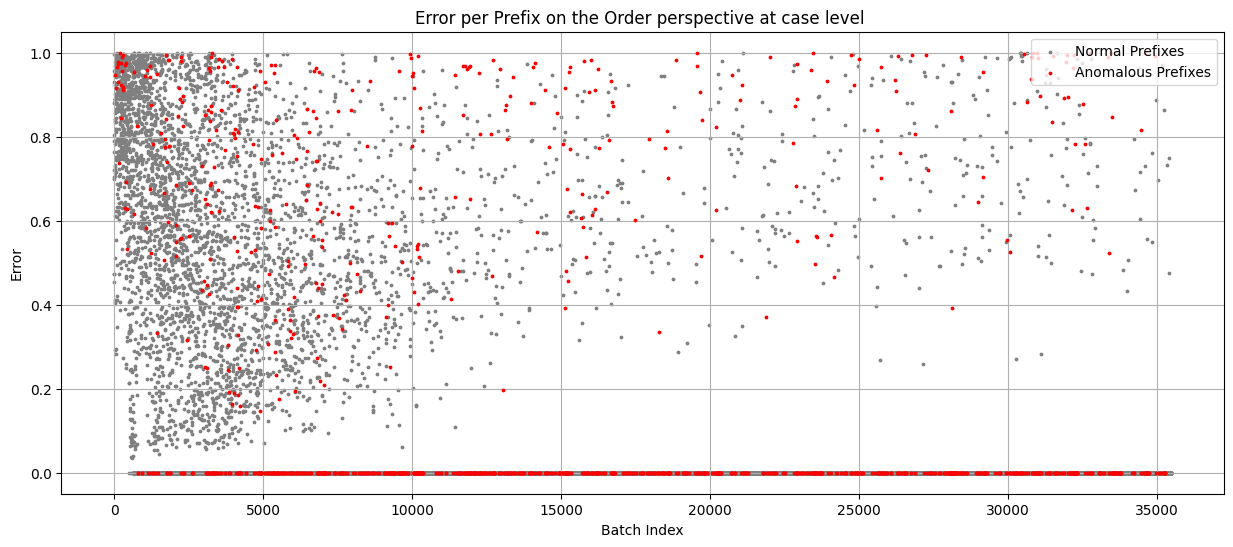

In [101]:
plot_losses(
    results=order_likelihood_errors, 
    labels=dataset.case_labels, 
    perspective=Perspective.ORDER, level='case', bucket=None, zoom=None)     

In [102]:
attribute_likelihood_errors = perspective_likelihood_errors[:,1:]

In [103]:
attribute_likelihood_errors_summed = np.mean(attribute_likelihood_errors, axis=1)

In [104]:
attribute_likelihood_errors.shape

(35483, 4)

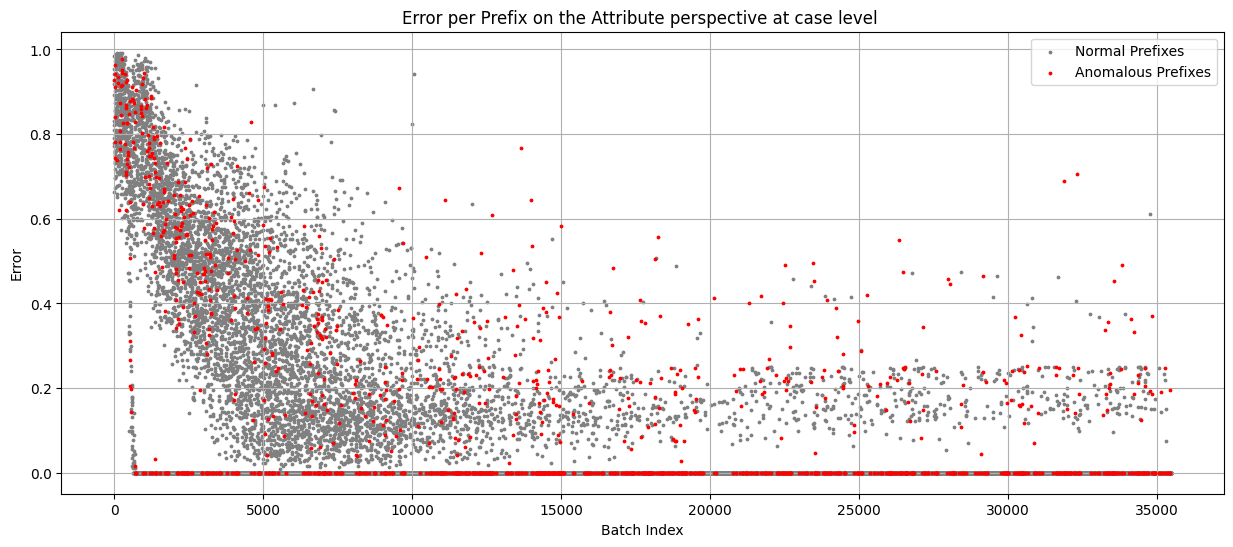

In [105]:
plot_losses(
    results=attribute_likelihood_errors_summed, 
    labels=dataset.case_labels, 
    perspective=Perspective.ATTRIBUTE, level='case', bucket=None, zoom=None)   

In [113]:
from sklearn.metrics import precision_recall_curve

def perspective_f1_score(true, pred):
    precision, recall, thresholds = precision_recall_curve(true, pred)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    return np.max(f1_scores)

In [118]:
order_f1 = perspective_f1_score(dataset.case_labels[:,Perspective.ORDER], order_likelihood_errors)
attribute_f1 = perspective_f1_score(dataset.case_labels[:,Perspective.ATTRIBUTE], attribute_likelihood_errors_summed)

In [122]:
print(f"F1-Score Order Case Level: \t {order_f1}")
print(f"F1-Score Attribute Case Level: \t {attribute_f1}")

F1-Score Order Case Level: 	 0.13933102648315784
F1-Score Attribute Case Level: 	 0.1382283772861938
